In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from PIL import Image
from methods.img_utils import image_grid_as_image
from datasets.nsd.nsd import NaturalScenesDataset
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.utils.nsd_utils import (get_roi_indices, parse_rois)

## Load data

In [58]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

subject = 1
data_root = './data/NSD'
hemisphere = 'right'
# roi = [
#     "floc-faces", 
#     "floc-words", 
#     "floc-places", 
#     "floc-bodies", 
#     "midventral",
#     "midlateral",
#     "midparietal",
#     "ventral",
#     "lateral",
#     "parietal"
# ]
roi = 'PPA'

nsd = NaturalScenesDataset(
    root=data_root,
    subject=subject,
    partition="train",
    hemisphere=hemisphere,
    roi=roi,
)

dataset = NSDCLIPFeaturesDataset(
    nsd=nsd,
    clip_extractor_type='clip_2_0',
    predict_average=True
)
del nsd

## Load noun classification and remove irrelevant

In [64]:
df = pd.read_csv('data/laion_nouns_classification.csv')
categories = list(df.columns[1:-2])

feeling_or_emotion = []
for i, row in df.iterrows():
    feeling_or_emotion.append((row['noun'], row['feeling or emotion'] >= max(row[1:])))
feeling_or_emotion = [noun for noun, is_feeling_or_emotion in feeling_or_emotion if is_feeling_or_emotion]

event = []
for i, row in df.iterrows():
    event.append((row['noun'], row['event'] >= max(row[1:])))
event = [noun for noun, is_event in event if is_event]

reject = feeling_or_emotion + event

## Load shift vectors

In [4]:
with open('data/laion_nouns.txt', 'r') as file:
    lines = file.readlines()
    nouns = [line.strip() for line in lines]

noun_vectors = []
noun_keep = []
for noun in nouns:
    if noun in reject:
        continue
    f = f'data/shift_vectors/nouns/{noun}.npy'
    noun_vectors.append(np.load(f))
    noun_keep.append(noun)
noun_vectors = np.stack(noun_vectors)
noun_vectors = torch.from_numpy(noun_vectors).float().to(device)

## Compute image categories

In [6]:
cosines = 1 - pairwise_distances(dataset.features, noun_vectors, metric='cosine')

ws = []
for i in tqdm(range(len(dataset))):
    order_image = np.argsort(cosines[i])[::-1][:100]
    nouns_image = np.array(noun_keep)[order_image]
    cosines_image = cosines[i][order_image]
    weights = np.array(df[df['noun'].isin(noun_keep)][categories])
    weights_image = weights[order_image]
    weights_image = weights_image * cosines_image[:, None] / weights.sum(0)
    weights_image = weights_image.sum(0) / weights_image.sum()
    ws.append(weights_image)
ws = np.stack(ws)

100%|██████████| 8969/8969 [00:27<00:00, 330.17it/s]


### Inspect categories

In [ ]:
for category in categories:

    print(category)

    idx = categories.index(category)

    order = np.argsort(ws[:, idx])

    min_idx = order[:25]
    min_imgs = [Image.open(os.path.join(dataset.nsd.root, dataset.nsd.df.iloc[idx]["filename"])) for idx in min_idx]
    min_img = image_grid_as_image(min_imgs, 5, 5)
    max_idx = order[-25:]
    max_imgs = [Image.open(os.path.join(dataset.nsd.root, dataset.nsd.df.iloc[idx]["filename"])) for idx in max_idx]
    max_img = image_grid_as_image(max_imgs, 5, 5)

    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(min_img)
    axes[0].axis('off')
    axes[1].imshow(max_img)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

### Inspect distribution of categories in ROI

In [ ]:
min_val = -np.ceil(np.abs(dataset.targets.numpy().min()*10))/10
max_val = np.ceil(np.abs(dataset.targets.numpy().max()*10))/10
val_range = np.arange(min_val, max_val+0.1, 0.1)
val_range = val_range[1:-1]
bins = [val_range[i:i+2] for i in range(len(val_range)-1)]

ws_binned = np.zeros((len(bins), len(categories)))
for i, (bmin, bmax) in enumerate(bins):
    idx = (dataset.targets >= bmin) & (dataset.targets < bmax)
    ws_binned[i] = ws[idx].mean(0)

color = np.array([plt.cm.tab20(i) for i in range(len(categories))])

plt.figure(figsize=(10, 5))
for i, cat in enumerate(categories):
    plt.plot(val_range[:-1], ws_binned[:, i], label=cat, color=color[i])
plt.xlim(val_range[0], val_range[-1])
# plt.legend()
plt.xlabel('Activation')
plt.ylabel('Average class weight')
plt.title('(Binned) Activation vs. class weight')
plt.tight_layout()
plt.show()

In [53]:
corrs = np.empty((len(categories), dataset.targets.shape[1]))

for i, cat in tqdm(enumerate(categories)):
    for j in range(dataset.targets.shape[1]):
        corrs[i,j] = np.corrcoef(dataset.targets.T[j], ws[:, i])[0,1]

0it [00:00, ?it/s]

12it [01:14,  6.21s/it]


In [54]:
locs = dataset.nsd.fs_coords[dataset.nsd.fs_indices]

indices = {}
for roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_names, roi_classes = parse_rois([roi])
    indices[roi] = get_roi_indices(dataset.nsd.subj_dir, roi_names, roi_classes, hemisphere)

In [ ]:
locs = dataset.nsd.fs_coords[dataset.nsd.fs_indices]
locs_hvc = locs[dataset.nsd.roi_indices]

plt.figure(figsize=(10, 10))
plt.scatter(locs_hvc[:, 0], locs_hvc[:, 1], color='gray', alpha=0.1)
for i, roi in enumerate(["EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]):
    color = plt.cm.tab20(i)
    locs_roi = locs[indices[roi]]
    plt.scatter(locs_roi[:, 0], locs_roi[:, 1], label=roi, color=color, alpha=0.5)
plt.axis('off')
# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
locs = dataset.nsd.fs_coords[dataset.nsd.fs_indices][dataset.nsd.roi_indices]

for i, cat in tqdm(enumerate(categories)):
    print(cat)
    plt.figure(figsize=(5, 5))
    plt.scatter(locs[:, 0], locs[:, 1], c=corrs[i], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    plt.axis('off')
    # plt.colorbar(label='Correlation with activations')
    plt.tight_layout()
    plt.show()

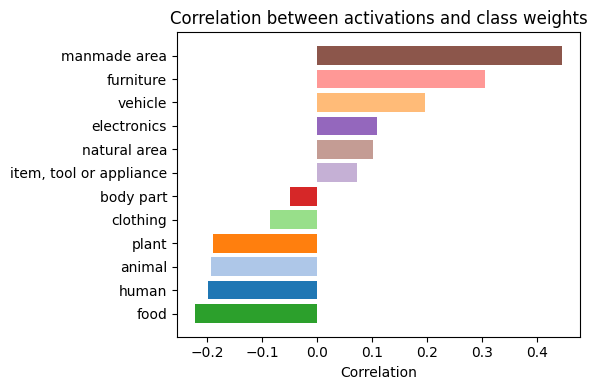

In [85]:
corrs = []
for i, cat in enumerate(categories):
    corr = np.corrcoef(dataset.targets.numpy(), ws[:, i])[0, 1]
    corrs.append(corr)

order = np.argsort(corrs)
corrs = np.array(corrs)[order]

plt.figure(figsize=(6, 4))
plt.barh(np.arange(len(categories)), corrs, color=color[order])
plt.yticks(np.arange(len(categories)), np.array(categories)[order])
plt.xlabel('Correlation')
plt.title('Correlation between activations and class weights')
plt.tight_layout()
plt.show()

### Inspect individual image

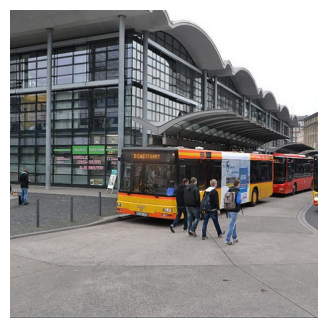

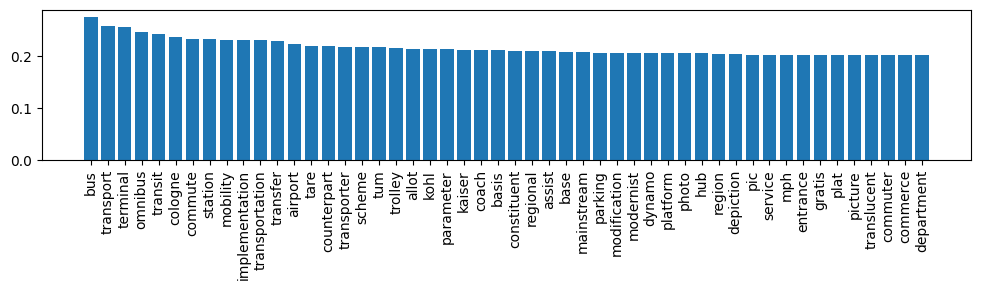

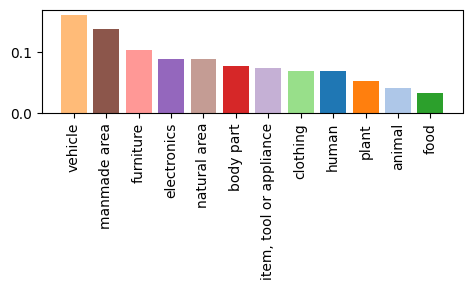

In [69]:
idx = np.random.randint(len(dataset))

img, features, _ = dataset[idx]

plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.show()

plt.figure(figsize=(10,3))
order = np.argsort(cosines[idx])[::-1]
plt.bar(np.array(noun_keep)[order][:50], cosines[idx][order][:50])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

order_image = np.argsort(cosines[idx])[::-1][:100]
nouns_image = np.array(noun_keep)[order_image]
cosines_image = cosines[idx][order_image]

weights = np.array(df[df['noun'].isin(noun_keep)][categories])
weights_image = weights[order_image]
weights_image = weights_image * cosines_image[:, None] / weights.sum(0)
weights_image = weights_image.sum(0) / weights_image.sum()

color = np.array([plt.cm.tab20(i) for i in range(len(categories))])

plt.figure(figsize=(5,3))
order = np.argsort(weights_image)[::-1]
plt.bar(np.array(categories)[order], weights_image[order], color=color[order])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0.11350227147340775 0.99999994


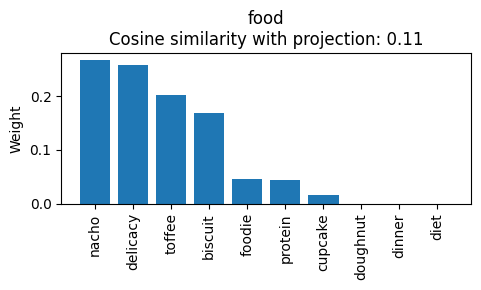

In [126]:
def decompose_vector(vector, noun_vectors):

    weights = torch.nn.Parameter(torch.randn(len(noun_vectors),1).to(device))
    optimizer = torch.optim.Adam([weights], lr=1e-3)

    n_epochs = 1000
    alpha = 1e-3
    sims = []
    for _ in range(n_epochs):
        with torch.no_grad():
            weights.clamp_(0)
            weights /= weights.abs().sum()
        pred = weights.T @ noun_vectors
        cosine_sim = F.cosine_similarity(pred, torch.from_numpy(vector).to(device).unsqueeze(0), dim=1)
        loss = -cosine_sim + alpha * weights.abs().sum()
        sims.append(cosine_sim.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        weights.clamp_(0)
        weights /= weights.abs().sum()
        pred = weights.T @ noun_vectors
    weights = weights.detach().cpu().numpy().squeeze()

    return weights, cosine_sim.item(), pred

from methods.high_level_attributes.shift_vectors import *

shift_vector = compute_for_activations(dataset.targets, dataset.features)[:,0]

cat = 'food'
    
df_candidate = df[df['noun'].isin(noun_keep)].reset_index(drop=True)
df_candidate = df_candidate[df_candidate[cat] > 0.5]
noun_vectors_candidate = noun_vectors[df_candidate.index]
noun_keep_candidate = np.array(noun_keep)[df_candidate.index]

weights, cosine_sim, pred = decompose_vector(-shift_vector, noun_vectors_candidate)
print(cosine_sim, weights.sum())

plt.figure(figsize=(5,3))
order = np.argsort(weights)[::-1][:10]
plt.bar(noun_keep_candidate[order], weights[order])
plt.title(f'{cat}\nCosine similarity with projection: {cosine_sim:.2f}')
plt.ylabel('Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [127]:
pred = pred.squeeze().detach().cpu().numpy()
np.save('food.npy', pred)